In [137]:
import urllib
import string
from itertools import compress
from nltk.corpus import stopwords 
import pandas as pd
from functools import reduce
import os
from bs4 import BeautifulSoup,SoupStrainer

In [138]:
directory = os.fsencode('data')
docs = []
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    f = open(f'data/{filename}', 'r')
    data= f.read()
    soup = BeautifulSoup(data)
    contents = soup.findAll('text')
    f.close()
    docs.append(str(contents).split('</text>'))

docs = [i for doc in docs for i in doc]

In [139]:
# split on </dateline> and keep everything after it
docs = list(compress(docs, ['</dateline>' in i for i in docs]))
docs = [i.split('</dateline>')[1] for i in docs]
docs = [i.lower().translate(str.maketrans('\n', ' ')) for i in docs]
docs = [i.translate(str.maketrans('\r', ' ')) for i in docs]
docs = [i.translate(str.maketrans('\x03', ' ')) for i in docs]
docs = [i.translate(str.maketrans('', '', string.punctuation)) for i in docs]
docs = [i.translate(str.maketrans('', '', string.digits)) for i in docs]
docs = [i.replace('said',' ') for i in docs] # another stop word
docs = [i.replace('reuter', ' ') for i in docs]
docs = [i.split() for i in docs]

In [140]:
def reducedVocab(lists, stop_words = None, min_word_count = 10):
    '''This function takes a list of words in a list of documents and returns the lists of lists with a reduced
       vocabulary, the flattened list, and the vocabulary'''
    
    if stop_words == None:
        stop_words = set(stopwords.words('english'))
    
    # Remove stop words
    words = [i for sublist in lists for i in sublist if not i in stop_words]

    # Remove words that appear less than min_word_count times
    wordSeries = pd.Series(words)
    vocab = list(compress(wordSeries.value_counts().index, wordSeries.value_counts() >= min_word_count))
    
    # Recreate lists with filtered vocab
    docs = []
    for j in range(len(lists)):
        docs.append([i for i in lists[j] if i in vocab])
    
    #flatten docs
    one_list = [i for sublist in docs for i in sublist]
    
    return docs, one_list, vocab

def listsToVec(lists, stop_words = None, min_word_count = 10, verbose = 1):
    '''
    This function takes a list of lists of the words in each document. It removes any stop words, removes words that
    appear 'min_word_count' times or less, and maps each word in the documents' vocabulary to a number. 
    Two flattened vectors are returned, the mapped numbers 'x', and the corresponding document each word belongs to 'j'.'''

    # Remove stop words and words that appear less than 'min_word_count' times
    docs, one_list, vocab = reducedVocab(lists, stop_words, min_word_count)
    
    # Map each word to a number
    #numbers = list(range(len(vocab)))
    #vocab_dict = dict(zip(vocab, numbers))
    #x = list(map(vocab_dict.get, one_list))
    
    # Check for empty lists and print warning if one is found
    counter = 0
    for i in range(len(docs)-1 ,-1, -1):
        if len(docs[i]) == 0:
            if verbose > 1:
                print(f'WARNING: Document {i} is empty and being removed...')
            del docs[i]
            counter += 1
    
    if verbose == 1 and counter > 1:
        print(f'WARNING: {counter} documents are empty and being removed...')
    
    elif verbose == 1 and counter == 1:
        print(f'WARNING: {counter} document is empty and being removed...')
    
    X_matrix = pd.DataFrame(np.zeros((len(one_list), len(vocab))),
                           columns=vocab)

    for i, word in enumerate(one_list):
        X_matrix.loc[i, word] = 1   
    
    # Determine which document each word belongs to
    count, j = 0, []
    for i in docs:
        j.append([count]*len(i))
        count += 1
        
    # Reduce to a flattened list
    j = [i for sublist in j for i in sublist]
    
    return X_matrix, j

In [166]:
import numpy as np


# Select random subset of the documents
selected = np.random.choice(len(docs), 110, replace = False)
subset_docs = [docs[i] for i in selected]

In [167]:
# Process subset of documents
docs, one_list, vocab = reducedVocab(subset_docs, min_word_count = 3)

## LDA Models

In [143]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LsiModel
from pprint import pprint
import re
import pandas as pd
import numpy as np
import string
import os
import matplotlib.pyplot as plt

In [265]:
def LDA_perplexity(docs, max_train_index, min_topics, max_topics):
    '''
    This function takes a list of lists (words in documents) and the number of documents you want in the training set.
    NOTE : max_train_index must be less than len(docs)
    
    It calculates the perplexity of the trained LDA model on the remaining unseen documents in 'docs' ranging
    from n_topics = min_topics to n_topics = max_topics
    '''
    
    assert max_train_index < len(docs), 'max_train_index must be less than the length of docs'
    assert min_topics <= max_topics, 'min_topics must be less than or equal to max_topics'
    
    train = docs[:max_train_index]
    test = docs[max_train_index:]
    N = len([i for sublist in test for i in sublist])
    
    train_2word = corpora.Dictionary(docs)
    train_corpus = [train_2word.doc2bow(doc) for doc in train]
    
    test_2word = corpora.Dictionary(docs)
    test_corpus = [test_2word.doc2bow(doc) for doc in test]
    
    log_perp = []
    for i in range(min_topics, max_topics + 1): 
        
        lda_model = gensim.models.ldamodel.LdaModel(corpus = train_corpus,
                                               id2word = train_2word,
                                               num_topics = i,
                                               random_state = 23,
                                               eval_every = 20,
                                               alpha = 'asymmetric',
                                               iterations = 50)
        
        tmp_perplex = lda_model.log_perplexity(test_corpus)
        log_perp.append(-tmp_perplex/N)
        
    perplexity = np.exp(log_perp)
    
    return perplexity
    

In [304]:
def plt_perplexity(perplexity, min_topics, max_topics):
    '''
    This function plots the perplexity given in the input.
    '''
    plt.plot(perplexity[1,:], perplexity[0,:])
    plt.xlabel('Number of LDA Topics')
    plt.xticks(np.arange(min_topics, max_topics, step=(max_topics - min_topics)//8))
    #plt.xticks(min_topics,max_topics)
    plt.ylabel('Perplexity')
    plt.title('Perplexity of LDA Model on Test Documents')
    plt.show()

In [266]:
perplexity = LDA_perplexity(docs, 100, 2, 40)

In [306]:
mat = np.zeros((2, 39))
mat[0,:] = perplexity
mat[1,:] = np.arange(2,41)

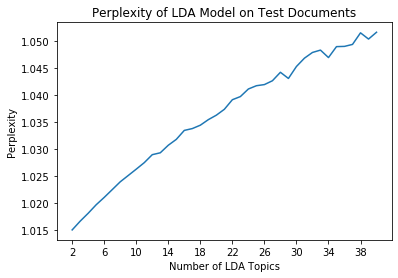

In [305]:
plt_perplexity(mat, 2, 40)

## Manually calculate Perplexity

In [307]:
train = docs[:100]
test = docs[100:]
    
train_2word = corpora.Dictionary(docs)
train_corpus = [train_2word.doc2bow(doc) for doc in train]
    
test_2word = corpora.Dictionary(docs)
test_corpus = [test_2word.doc2bow(doc) for doc in test]
    
lda_model = gensim.models.ldamodel.LdaModel(corpus = train_corpus,
                                               id2word = train_2word,
                                               num_topics = 4,
                                               random_state = 23,
                                               eval_every = 20,
                                               alpha = 'asymmetric',
                                               iterations = 50)

lda_model.get_document_topics(test_corpus, minimum_probability = 1e-8, per_word_topics = True)       
    
new_topics = lda_model[test_corpus]

# Theta for a single document
theta = [e for _, e in new_topics[0][0]]

# Phi for a single document
phi = []
for i in range(len(new_topics[0][2])):
    first, second = new_topics[0][2][i]
    phi.append([e for _, e in second])

# Perplexity
np.exp(sum(-np.log(np.inner(theta[:2], np.array(phi))))/15)


1.1818179506098327

## LSA Models

In [308]:
def LSA_perplexity(docs, max_train_index, min_topics, max_topics):
    '''
    This function takes a list of lists (words in documents) and the number of documents you want in the training set.
    NOTE : max_train_index must be less than len(docs)
    
    It calculates the perplexity of the trained LDA model on the remaining unseen documents in 'docs' ranging
    from n_topics = min_topics to n_topics = max_topics
    '''
    
    assert max_train_index < len(docs), 'max_train_index must be less than the length of docs'
    assert min_topics <= max_topics, 'min_topics must be less than or equal to max_topics'
    
    train = docs[:max_train_index]
    test = docs[max_train_index:]
    
    train_2word = corpora.Dictionary(train)
    train_corpus = [train_2word.doc2bow(doc) for doc in train]
    
    test_2word = corpora.Dictionary(test)
    test_corpus = [test_2word.doc2bow(doc) for doc in test]
    
    perplexity = []
    for i in range(min_topics, max_topics + 1): 
        
        lsa_model = LsiModel(corpus = train_corpus,
                                      id2word = train_2word,
                                      num_topics = i)
        
        # Still need to calculate perplexity
        
    

## LDA on Paper Data

In [151]:
url = 'https://raw.githubusercontent.com/tdhopper/topic-modeling-datasets/master/data/raw/Nematode%20biology%20abstracts/cgcbib.txt'
file = urllib.request.urlopen(url)
data = file.read().decode("ISO-8859-1")

In [152]:
def docsToList(data):
    '''
    This function takes a string of abstracts and converts it to a list of lists of the words in each abstract.
    This function was made specifically for the data obtained here:
    https://raw.githubusercontent.com/tdhopper/topic-modeling-datasets/master/data/raw/Nematode%20biology%20abstracts/cgcbib.txt
    '''
    
    # Remove '\n' and '\r'
    data = data.lower().translate(str.maketrans('\n', ' '))
    data = data.translate(str.maketrans('\r', ' '))
    
    # Remove punctuation except for '-' so we can split after each abstract
    data = data.translate(str.maketrans('', '', '!"#$%&\'()*+,./;<=>?@[\\]^_`{|}~'))
    
    # Remove numbers
    data = data.translate(str.maketrans('','', string.digits))
    
    # Split after 'abstract' is stated
    data = data.split('-------------------')
    # Remove '-' punctuation now
    data = [abstract.translate(str.maketrans('-', ' ')) for abstract in data]
    
    # Remove entries without the word "abstract" in it
    abs_check = ['abstract' in i for i in data]
    data = list(compress(data, abs_check))

    # Only keep the words after 'abstract'
    data = [abstract.split('abstract:')[1] for abstract in data]
    
    # Remove any remaining :'s
    data = [abstract.translate(str.maketrans(':', ' ')) for abstract in data]
    
    # Remove abstracts that only state 'in french'
    not_french = ['in french' not in i for i in data]
    data = list(compress(data, not_french))
    
    # Create list of lists output
    output = [i.split() for i in data]
    
    return output

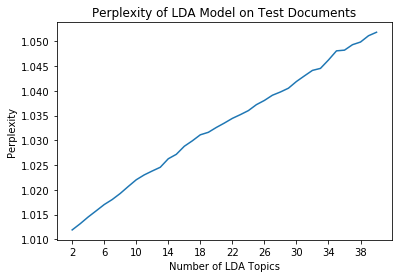

In [309]:
lists = docsToList(data)
lists = lists[:110]
perplexity = LDA_perplexity(lists, 100, 2, 40)
mat = np.zeros((2, 39))
mat[0,:] = perplexity
mat[1,:] = np.arange(2,41)

plt_perplexity(mat, 2, 40)

## Perplexity generally decreases as the number of topics increases. 

My manual calculation of perplexity for a document appears to be consistent for perplexity for the test corpus calculated by gensim's log_perplexity. There are posts online about gensim's log_perplexity having this problem, and the creators say they will address it but possibly never have? 